## CutMix, Mixup exp
- 초기 실험 중요
  - 얼마나 걸리는지.. 등..을 확인 후에, **자원을 효율적으로 사용**하기 위하여 초기 실험의 환경을 설정해야 함
  - 뭘 먼저 확인할 건지 우선 순위 설정도 해야 함
- 오버피팅 지점이 어디..? -> 각 모델의 오버피팅을 확인해야함
- 테스트 데이터를 이용해서 진짜 잘 나오는지 확인
  - 오버피팅 전 && 최적화 모델
- 중간 중간 기록하기
- Training loss와 validation accuracy 비교
- 그래프를 세로로 놓으면 에폭을 비교하기 편함

### 테스트 준비
- 데이터 셋 정보 확인  
  ![dataset.png](./images/dataset.png)  
  ![ds_info.png](./images/ds_info.png)  

- 데이터 증강 결과 확인  
  - 기본 augmentation  
    ![basic_aug_result](./images/basic-aug-result.png)  
  - Mixup  
    ![mixup_result](./images/mixup_result.png)
  - Cutmix  
    ![cutmix_result](./images/cutmix_result.png)

### 예측 함수

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
num_classes = ds_info.features["label"].num_classes

In [3]:
IMAGE_SIZE=224

def predict(image_path, ds_info, model, debug=False):
    test_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    if debug:
        plt.imshow(test_image)
        plt.show()
    
    # preprocess
    test_image = tf.image.resize(test_image, (IMAGE_SIZE, IMAGE_SIZE))
    test_image = tf.cast(test_image, tf.float32) / 255.
    if debug:
        plt.imshow(test_image)
        plt.show()
    
    # reshape to adjust the batch dimension
    test_image = tf.expand_dims(test_image, axis=0)
    
    # predict
    output = model.predict(test_image)
    
    label_index = np.argmax(output)
    label = ds_info.features['label'].int2str(label_index)

    return label_index, label

In [4]:
golden_path = os.getenv('HOME')+"/aiffel/data_augmentation/data/Golden-Retriever.jpg"
tibetan_terrier_path = os.getenv('HOME')+"/aiffel/data_augmentation/data/tibetan_terrier.jpg"
affenpinscher_path = os.getenv('HOME')+"/aiffel/data_augmentation/data/affenpinscher.jpg"

### 3.1 초기 실험
[Aumentation 없는 실험으로 이동](./0226_image_augmentation-without-aug.ipynb)
#### **세팅**  
- Augmentation하지 않은 데이터 셋
- ResNet-50
- 충분히 학습해서 overfitting 시킬 것
- 한 epoch에 대략 2:30정도..
- 6번째 epoch부터 벌써 validation loss가 개선되지 않음 -> 일단 15 epochs까지만 돌리고 찍어보자..  

#### **초기 실험 결과 분석**  
![resnet-without-aug-acc-1.png](./images/resnet-without-aug-acc-1.png)  
![resnet-without-aug-history.png](./images/resnet-without-aug-history.png)  
- Training accuracy가 거의 1에 수렴
- Training loss 역시 0에 수렴
  -  Overfitting 패턴
- Validation accuracy는 특정 구간에서 정체
- Validation loss는 살짝 올라가는 것 같으나, 심하지 않음
  - Overfitting 패턴은 맞지만, validation loss 가 많이 증가하지는 않음
  - **Epoch 2-4**정도부터 validation loss가 증가하는 것으로 보임
  - 스케일을 높여서 검증 손실이 얼마나 올라가는지 확인도 가능할 듯 (하지만 history를 저장하지 않음 ㅠ)
- 학습 정확도가 1에 수렴했지만 검증 정확도는 0.73 정도로, 견종 데이터의 공간을 완전히 파악한 것으로 보이지는 않음
  - 학습 데이터에 너무 빨리 수렴함, 학습 속도를 조절해 볼 수 있을 듯 (하지만 시간 관계상 스킵..)

#### **문제 파악**  
- 첫 번째는 데이터 셋 자체가 적은 것 -> 제대로 학습이 불가능
- 일반화 성능 향상을 위한 세팅이 없음
  - 규제
  - 데이터 증강

#### **예측**  
- 저장한 모델의 가중치를 불러와서 예측 실행
- `save_best_only=True` 옵션을 사용해서 성능이 더 좋아졌을 때만 저장
  - 오버피팅이 발생한 후에는 모델의 가중치가 저장되지 않음을 로그에서 확인할 수 있음

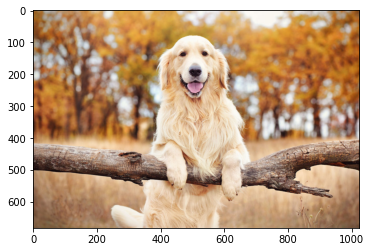

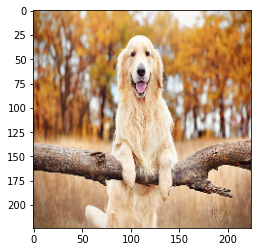

56 n02099601-golden_retriever


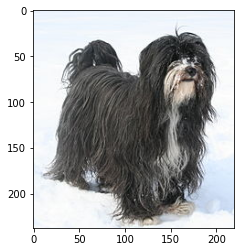

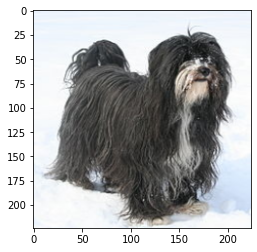

100 n02110627-affenpinscher


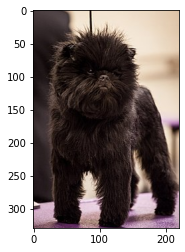

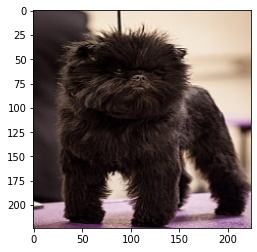

100 n02110627-affenpinscher


In [ ]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

resnet50_checkpoint_path = os.getenv('HOME')+"/aiffel/data_augmentation/checkpoint/no_aug_checkpoint.weights.h5"
resnet50.load_weights(resnet50_checkpoint_path)

golden_idx, golden_label = predict(golden_path, ds_info, resnet50, debug=True)
print(golden_idx, golden_label)

tibetan_idx, tibetan_label = predict(tibetan_terrier_path, ds_info, resnet50, debug=True)
print(tibetan_idx, tibetan_label)

affenpinscher_idx, affenpinscher_label = predict(affenpinscher_path, ds_info, resnet50, debug=True)
print(affenpinscher_idx, affenpinscher_label)

| ResNet 50        | prediction       |   |
|------------------|------------------|---|
| golden_retriever | golden_retriever | o |
| tibetan_terrier  | affenpinscher    | x |
| affenpinscher    | affenpinscher    | o |

### 3.2 Basic Augmentation
[Basic augmentation 실험으로 이동](./0226_image_augmentation-basic-aug.ipynb)  
- 여기서 부터는 저장해놓은 history 값과 model checkpoint를 이용해 확인

In [65]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [66]:
def get_top_3_points(target_list):
    top_3_indices = target_list.argsort()[-3:][::-1]
    return [(epoch, target_list[epoch]) for epoch in top_3_indices]

In [87]:
def visualize_history_from_csv(csv_path, title, start_epoch=0, end_epoch=None, with_gap=False, vertical=False):
    history_frame = pd.read_csv(csv_path)

    if end_epoch == None:
        end_epoch = history_frame.index[-1]

    history = history_frame[(history_frame.index >= start_epoch) & (history_frame.index <= end_epoch)]
    top_3 = get_top_3_points(np.array(history['val_accuracy']))

    if vertical:
        plt.figure(figsize=(6, 8))
    else:
        plt.figure(figsize=(12, 5))

    if with_gap:
        accuray_gap = history['accuracy'] - history['val_accuracy']
        loss_gap = history['val_loss'] - history['loss']

    # Plot accuracy
    if vertical:
        plt.subplot(2, 1, 1)
    else:
        plt.subplot(1, 2, 1)
    plt.plot(history.index, history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.index, history['accuracy'], label='Training Accuracy')

    if with_gap:
        plt.plot(history.index, accuray_gap, label='Accuracy Gap (Train - Val)', linestyle='dashed')

    for idx, (epoch, acc) in enumerate(top_3):
        plt.scatter(epoch, acc, color='red')
        plt.text(epoch, acc, f'{acc:.4f}', va='bottom' if idx % 2 == 1 else 'top')
        
    plt.title(f'{title} - Accuracy')
    plt.legend()

    # Plot loss
    if vertical:
        plt.subplot(2, 1, 2)
    else:
        plt.subplot(1, 2, 2)
    plt.plot(history.index, history['val_loss'], label='Validation Loss')
    plt.plot(history.index, history['loss'], label='Training Loss')
    if with_gap:
        plt.plot(history.index, loss_gap, label='Loss Gap (Val - Train)', linestyle='dashed')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.show()
    

In [56]:
# aug_csv_path = os.getenv('HOME')+"/aiffel/data_augmentation/history/history_resnet50_aug.csv"
aug_csv_path = "histories/history_resnet50_aug.csv"

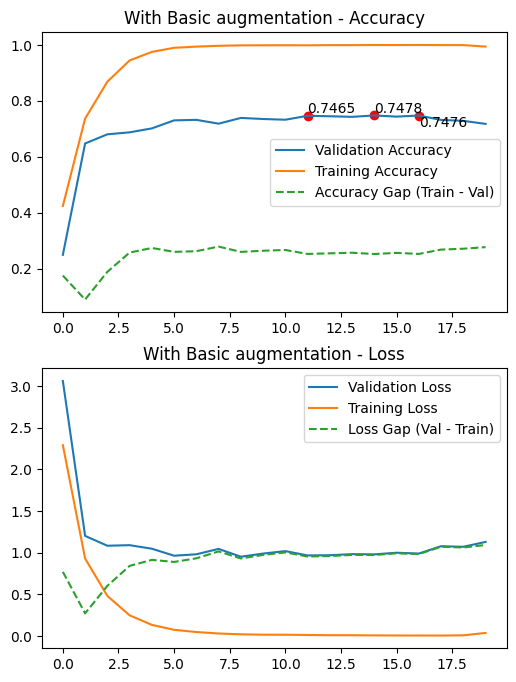

In [86]:
visualize_history_from_csv(aug_csv_path, "With Basic augmentation", with_gap=True, vertical=True)

- Overfitting 발생 지점이 **5-8 epoch** 정도로 늘어남

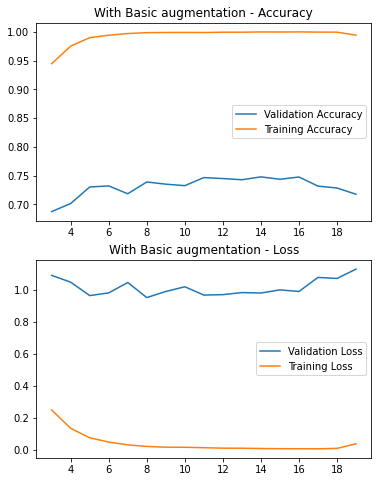

In [10]:
visualize_history_from_csv(aug_csv_path, "With Basic augmentation", start_epoch=3, vertical=True)

- 조금 범위를 크게 보자..
- 다섯번째 epoch부터 overfitting 슬슬 발생하는 것 같음
- 크게 개선점은 보이지 않음

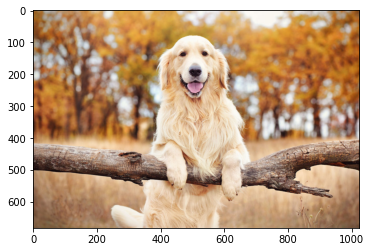

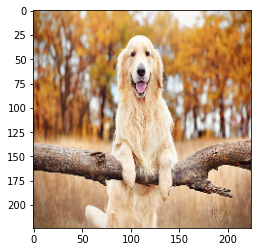

56 n02099601-golden_retriever


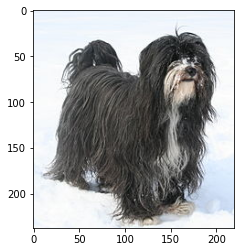

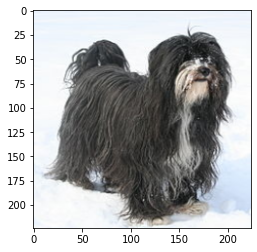

100 n02110627-affenpinscher


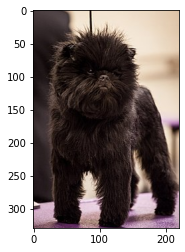

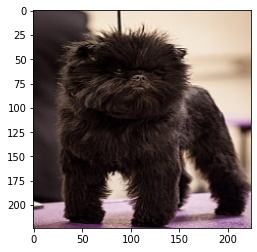

100 n02110627-affenpinscher


In [11]:
resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

resnet50_aug_checkpoint_path = os.getenv('HOME')+"/aiffel/data_augmentation/checkpoint/aug_checkpoint.weights.h5"
resnet50_aug.load_weights(resnet50_aug_checkpoint_path)

golden_idx, golden_label = predict(golden_path, ds_info, resnet50_aug, debug=True)
print(golden_idx, golden_label)

tibetan_idx, tibetan_label = predict(tibetan_terrier_path, ds_info, resnet50_aug, debug=True)
print(tibetan_idx, tibetan_label)

affenpinscher_idx, affenpinscher_label = predict(affenpinscher_path, ds_info, resnet50_aug, debug=True)
print(affenpinscher_idx, affenpinscher_label)

**결과**  

| ResNet 50 + Augmentation | prediction       |   |
|--------------------------|------------------|---|
| golden_retriever         | golden_retriever | o |
| tibetan_terrier          | affenpinscher    | x |
| affenpinscher            | affenpinscher    | o |

### 3.3 Basic Augmentation + Dropout + L2 Regularization
[Basic augmentation + Dropout + L2 Regularization 실험으로 이동](./0226_image_augmentation-basic-aug-reg.ipynb)  
- 규제를 줘서 일반화 성능을 좀 높여볼까..
  - Dropout 0.5
  - L2 Regularization 0.0001

In [57]:
# aug_reg_csv_path = os.getenv('HOME')+"/aiffel/data_augmentation/history/history_resnet50_aug_reg.csv"
aug_reg_csv_path = "histories/history_resnet50_aug_reg.csv"

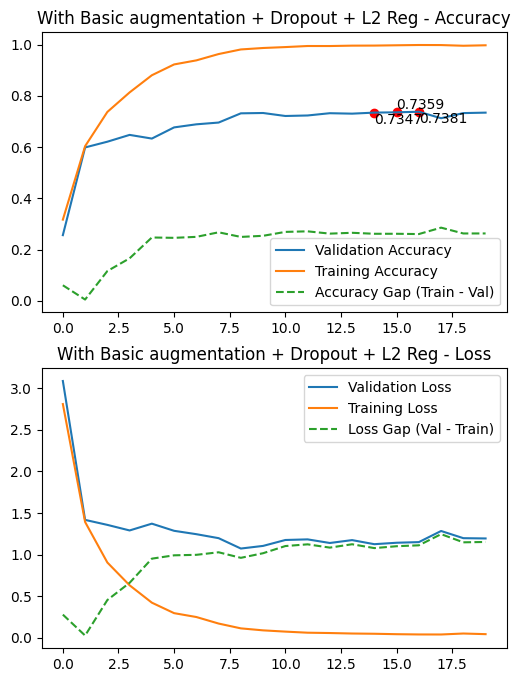

In [88]:
visualize_history_from_csv(aug_reg_csv_path, "With Basic augmentation + Dropout + L2 Reg", with_gap=True, vertical=True)

- Overfitting 발생 지점이 **8-10 epoch** 정도로 늘어남

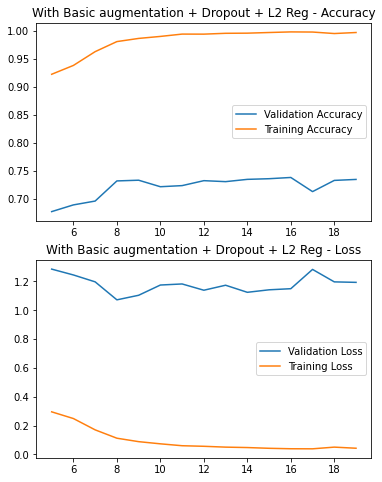

In [14]:
visualize_history_from_csv(aug_reg_csv_path, "With Basic augmentation + Dropout + L2 Reg", start_epoch=5, vertical=True)

- 8번째 epoch부터 오버피팅 시작
- 앞에 basic augmentation만 했을 때 보다 성능이 조금 개선되긴 함

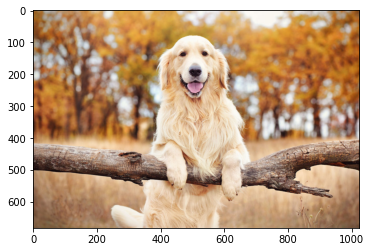

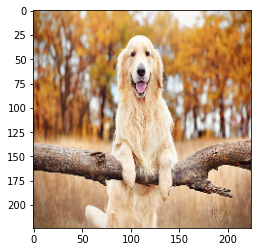

56 n02099601-golden_retriever


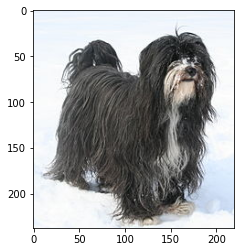

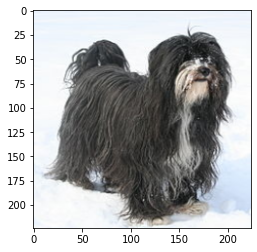

49 n02097474-tibetan_terrier


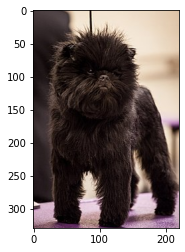

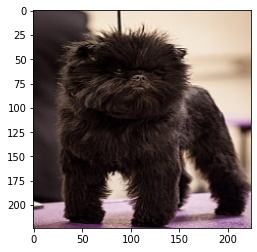

100 n02110627-affenpinscher


In [15]:
resnet50_aug_reg = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

resnet50_aug_reg_checkpoint_path = os.getenv('HOME')+"/aiffel/data_augmentation/checkpoint/aug_reg_checkpoint.weights.h5"
resnet50_aug_reg.load_weights(resnet50_aug_reg_checkpoint_path)

golden_idx, golden_label = predict(golden_path, ds_info, resnet50_aug_reg, debug=True)
print(golden_idx, golden_label)

tibetan_idx, tibetan_label = predict(tibetan_terrier_path, ds_info, resnet50_aug_reg, debug=True)
print(tibetan_idx, tibetan_label)

affenpinscher_idx, affenpinscher_label = predict(affenpinscher_path, ds_info, resnet50_aug_reg, debug=True)
print(affenpinscher_idx, affenpinscher_label)

**결과**  

| ResNet 50 + Augmentation + DR + REG | prediction       |   |
|-------------------------------------|------------------|---|
| golden_retriever                    | golden_retriever | o |
| tibetan_terrier                     | tibetan_terrier  | o |
| affenpinscher                       | affenpinscher    | o |

- 중간 티벳 테리어 견종을 드디어 예측해냄

----

- 여기까지 검증 정확도는 1에, 검증 손실은 거의 0에 수렴함
- 손실 갭은 거의 검증 손실과 비슷해짐

### 3.4 Basic + Mixup Augmentation
[Basic + Mixup Augmentation 실험으로 이동](./0227_image_augmentation_mixup_aug.ipynb)  

![mixup-overffiting.png](./images/mixup-overfitting.png)
- Epoch 수를 30으로 하였을 때 plot
- Validation loss가 training loss에 비해 높은 값을 가짐
  - Mixup 기법을 통해 학습 데이터를 증강하여, 학습 데이터가 테스트 데이터보다 복잡한 특성을 가짐
  - 20-25 사이에서부터 overfitting이 시작되는 것으로 보이나, 조금 더 보고 싶으니 `epoch=40`으로 다시 실행

In [59]:
# mixup_csv_path = os.getenv('HOME')+"/aiffel/data_augmentation/history/history_resnet50_mixup_aug.csv"
mixup_csv_path = "histories/history_resnet50_mixup_aug.csv"

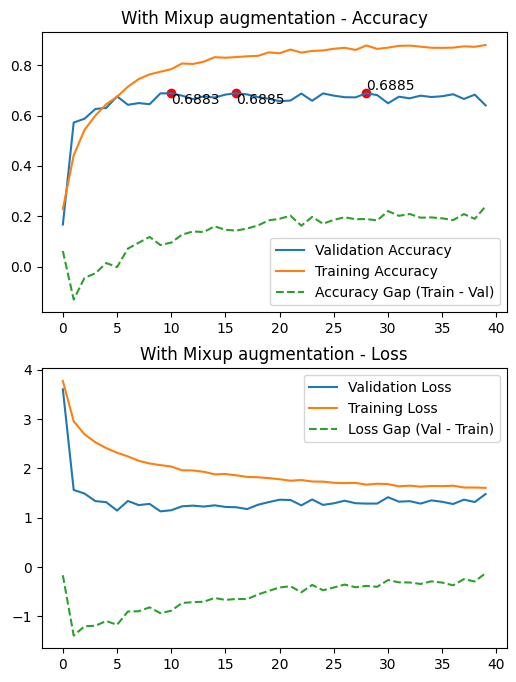

In [89]:
visualize_history_from_csv(mixup_csv_path, "With Mixup augmentation", with_gap=True, vertical=True)

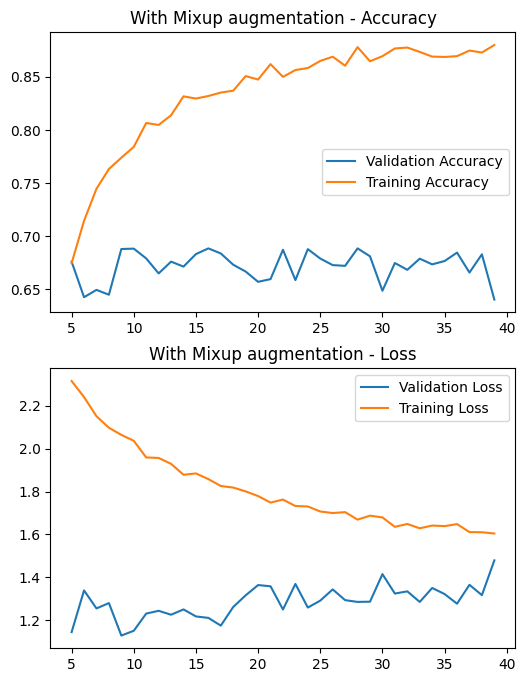

In [61]:
visualize_history_from_csv(mixup_csv_path, "With Mixup augmentation", start_epoch=5, vertical=True)

- 40 epoch까지 다시 돌리고 스케일을 크게 해서 확인해보니, 이 방법도 **10-15 epoch** 즈음 오버피팅이 시작하는듯
- 로스 간의 갭이 줄어들긴 하는데 과연 이게 좋은 의미일까?
  - 보통의 데이터셋과 모델에서는 보통 검증 손실이 학습 손실보다 크기 때문에, 로스의 갭이 가장 작은 부분에서의 웨이트를 사용하는 것이 성능에 좋을 것 같음
  - 근데 해당 경우는, 학습 손실을 적어지지만 검증 손실은 높아지고 있는 상황이라, 갭이 작은게 마냥 좋다고 할 수는 없을 듯
- 오버피팅 되는 지점이 10-15 epoch 정도로, 일반화 성능이 향상되긴 한 듯..

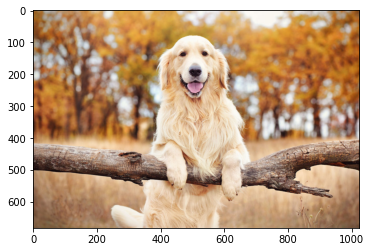

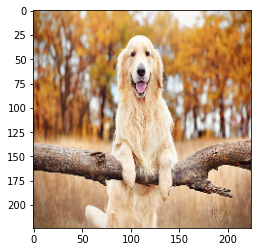

56 n02099601-golden_retriever


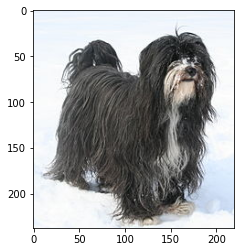

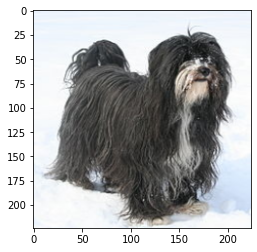

100 n02110627-affenpinscher


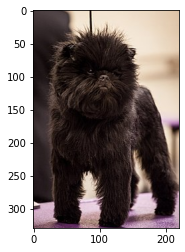

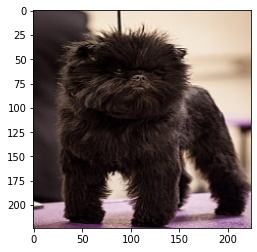

100 n02110627-affenpinscher


In [16]:
resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

resnet50_mixup_checkpoint_path = os.getenv('HOME')+"/aiffel/data_augmentation/checkpoint/mixup_aug_checkpoint.weights.h5"
resnet50_mixup.load_weights(resnet50_mixup_checkpoint_path)

golden_idx, golden_label = predict(golden_path, ds_info, resnet50_mixup, debug=True)
print(golden_idx, golden_label)

tibetan_idx, tibetan_label = predict(tibetan_terrier_path, ds_info, resnet50_mixup, debug=True)
print(tibetan_idx, tibetan_label)

affenpinscher_idx, affenpinscher_label = predict(affenpinscher_path, ds_info, resnet50_mixup, debug=True)
print(affenpinscher_idx, affenpinscher_label)

**결과**  

| ResNet 50 + Augmentation + Mixup | prediction       |   |
|----------------------------------|------------------|---|
| golden_retriever                 | golden_retriever | o |
| tibetan_terrier                  | affenpinscher    | x |
| affenpinscher                    | affenpinscher    | o |

### 3.4 Basic + Cutmix Augmentation
[Basic + Cutmix Augmentation 실험으로 이동](./0227_image_augmentation-cutmix-aug.ipynb)  

![cutmix-overfitting.png](./images/cutmix-overfitting.png)
- Mixup augmentation을 사용한 실험과 유사하게, validation loss가 training loss에 비해 높은 값을 가짐
  - 이 또한, cutmix 증강 기법으로 인해, 학습 데이터는 복잡하고 테스트 데이터는 비교적 단순해 진 결과일 듯
- Cutmix 기법은 epoch 10-15 사이에서 overfitting이 시작되는 것으로 보임

In [62]:
# cutmix_csv_path = os.getenv('HOME')+"/aiffel/data_augmentation/history/history_resnet50_cutmix.csv"
cutmix_csv_path = "histories/history_resnet50_cutmix.csv"

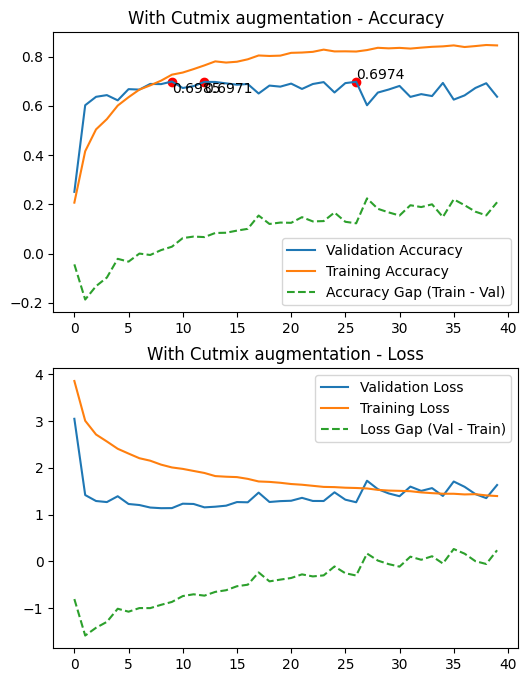

In [90]:
visualize_history_from_csv(cutmix_csv_path, "With Cutmix augmentation", with_gap=True, vertical=True)

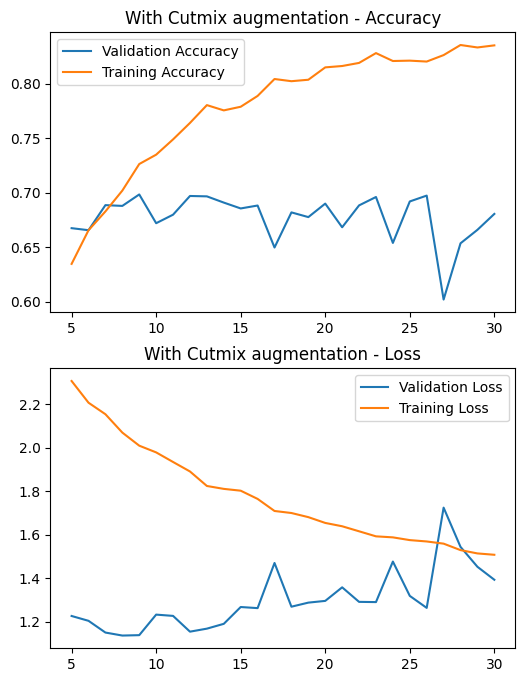

In [63]:
visualize_history_from_csv(cutmix_csv_path, "With Cutmix augmentation", start_epoch=5, end_epoch=30, vertical=True)

- **10-15 epoch** 즈음 오버피팅이 시작하는듯

```
Epoch 9/40
750/750 [==============================] - 160s 214ms/step - loss: 2.0691 - accuracy: 0.7020 - val_loss: 1.1366 - val_accuracy: 0.6880

Epoch 00009: val_loss improved from 1.15036 to 1.13660, saving model to /aiffel/aiffel/data_augmentation/checkpoint/cutmix_checkpoint.weights.h5
```
- 로그를 보면 epoch 9번째에서 웨이트를 마지막으로 저장한 것으로 보임
- 해당 모델을 불러서 확인해보자

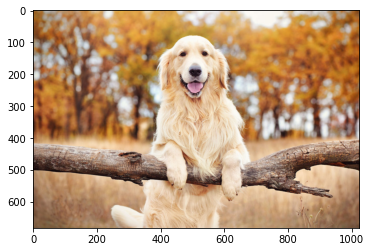

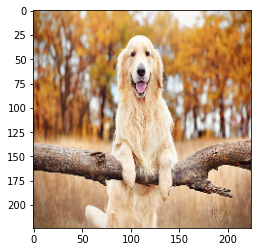

56 n02099601-golden_retriever


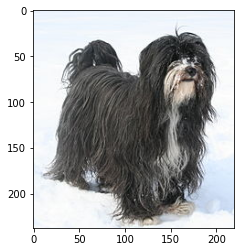

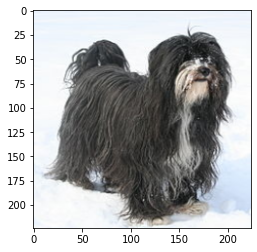

100 n02110627-affenpinscher


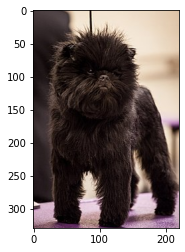

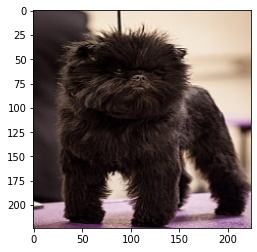

100 n02110627-affenpinscher


In [19]:
resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

resnet50_cutmix_checkpoint_path = os.getenv('HOME')+"/aiffel/data_augmentation/checkpoint/cutmix_checkpoint.weights.h5"
resnet50_cutmix.load_weights(resnet50_cutmix_checkpoint_path)

golden_idx, golden_label = predict(golden_path, ds_info, resnet50_cutmix, debug=True)
print(golden_idx, golden_label)

tibetan_idx, tibetan_label = predict(tibetan_terrier_path, ds_info, resnet50_cutmix, debug=True)
print(tibetan_idx, tibetan_label)

affenpinscher_idx, affenpinscher_label = predict(affenpinscher_path, ds_info, resnet50_cutmix, debug=True)
print(affenpinscher_idx, affenpinscher_label)

**결과**  

| ResNet 50 + Augmentation + Cutmix | prediction       |   |
|-----------------------------------|------------------|---|
| golden_retriever                  | golden_retriever | o |
| tibetan_terrier                   | affenpinscher    | x |
| affenpinscher                     | affenpinscher    | o |

- Overfitting은 맞는 것 같은데, 데이터 셋 자체가 적고 학습 데이터랑 검증 데이터랑 비슷한 분포를 가지고 있는 듯..
- 스케일을 높여서 확인도 가능할 듯 (하지만 history를 저장하지 않음 ㅠ)

### 5. Augmentation에 의한 모델 성능 비교 및 회고

#### 5.1. 실험 비교군
- No Augmentation : Baseline
- 기본 Augmentation
- 기본 Augmentation + Regularization
- 기본 + CutMix 적용
- 기본 + Mixup 적용

|                | No Aug | Aug  | Aug + Reg | Mixup | Cutmix |
|----------------|--------|------|-----------|-------|--------|
| Validation Acc | 0.74   | 0.75 | 0.74      | 0.69  | 0.70   |

#### 5.2 간단한 예측 결과

|                  | No Aug | Aug | Aug + Reg | Mixup | Cutmix |
|------------------|--------|-----|-----------|-------|--------|
| golden_retriever | o      | o   | o         | o     | o      |
| tibetan_terrier  | x      | x   | o         | x     | x      |
| affenpinscher    | o      | o   | o         | o     | o      |

- 세 후보군만 사용하여 예측해서 비교군이 적지만, 중간 견종(tibetan_terrier)이 헷갈리기 쉬운 데이터이기 때문에 의미 있는 실험이라 할 수 있음

#### 5.3 회고
- 데이터 셋이 적은 경우, 일반화 성능의 향상을 위해 데이터 증강, 규제 추가 등을 수행해 볼 수 있음
- Mixup 혹은 cutmix 증강 기법을 사용하여, 범주의 구분이 모호한 경계 영역 부분을 학습할 수 있을 것이라 기대했으나, 딱히 잘 학습한 것 같지는 않음
- 학습 데이터가 복잡해져서 학습을 오래 해야할 것 같았으나, 생각보다 빠르게 검증 데이터에 대해 성능이 나빠지기 시작
- 데이터의 퀄리티가 중요할까 양이 중요할까? 흠..